This notebook is inspired from Tendo's work and heavily borrows the code from [SNAPWorth](https://colab.research.google.com/github/tezike/snapworth/blob/master/00_Snapworth.ipynb) but apply it on ImageNette dataset.

In [1]:
%%capture
!pip install -q fastai2 fastcore
!pip install -q nbdev
!pip install -q azure-cognitiveservices-search-imagesearch sentencepiece dtreeviz

# Upload utils.py from fastai repository
!wget https://raw.githubusercontent.com/fastai/fastbook/master/utils.py

from pathlib import Path

# Setup images
(Path.cwd()/'images').mkdir(exist_ok=True)
! wget -P ./images https://github.com/fastai/fastbook/raw/master/images/grizzly.jpg

In [57]:
# make your Google Drive accessible
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive"
drive_data = f"{root_dir}/Colab Notebooks/rakuten/models"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from fastai2.vision.all import *

ImageNette: Slightly easier than ImageWoof, 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute)

In [3]:
path = untar_data(URLs.IMAGENETTE)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/val')]

In [5]:
(path/'train').ls()

(#10) [Path('/root/.fastai/data/imagenette2/train/n03417042'),Path('/root/.fastai/data/imagenette2/train/n03445777'),Path('/root/.fastai/data/imagenette2/train/n03394916'),Path('/root/.fastai/data/imagenette2/train/n01440764'),Path('/root/.fastai/data/imagenette2/train/n03000684'),Path('/root/.fastai/data/imagenette2/train/n03028079'),Path('/root/.fastai/data/imagenette2/train/n02102040'),Path('/root/.fastai/data/imagenette2/train/n03888257'),Path('/root/.fastai/data/imagenette2/train/n03425413'),Path('/root/.fastai/data/imagenette2/train/n02979186')]

In [6]:
(path/'val').ls()

(#10) [Path('/root/.fastai/data/imagenette2/val/n03417042'),Path('/root/.fastai/data/imagenette2/val/n03445777'),Path('/root/.fastai/data/imagenette2/val/n03394916'),Path('/root/.fastai/data/imagenette2/val/n01440764'),Path('/root/.fastai/data/imagenette2/val/n03000684'),Path('/root/.fastai/data/imagenette2/val/n03028079'),Path('/root/.fastai/data/imagenette2/val/n02102040'),Path('/root/.fastai/data/imagenette2/val/n03888257'),Path('/root/.fastai/data/imagenette2/val/n03425413'),Path('/root/.fastai/data/imagenette2/val/n02979186')]

In [7]:
items = get_image_files(path)

In [8]:
split_idx = GrandparentSplitter(train_name='train', valid_name='val')(items)

In [9]:
L(split_idx[0]), L(split_idx[1])

((#9469) [0,1,2,3,4,5,6,7,8,9...],
 (#3925) [9469,9470,9471,9472,9473,9474,9475,9476,9477,9478...])

In [10]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [11]:
L(lbl_dict.values())

(#10) ['tench','English springer','cassette player','chain saw','church','French horn','garbage truck','gas pump','golf ball','parachute']

In [12]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]

In [13]:
tfms

[[<bound method PILBase.create of <class 'fastai2.vision.core.PILImage'>>],
 [<function fastai2.data.transforms.parent_label>,
  <function dict.__getitem__>,
  Categorize: (object,object) -> encodes (object,object) -> decodes]]

In [14]:
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

### Dataset

In [15]:
dsets = Datasets(items, tfms, splits=split_idx)

In [16]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

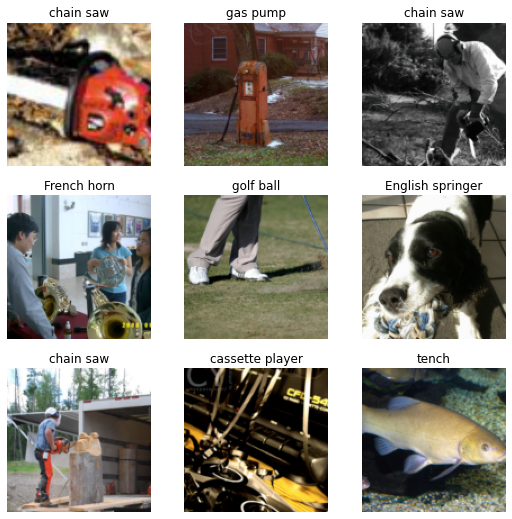

In [17]:
dls.show_batch()

In [18]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [19]:
learn.validate()

(#2) [3.3916542530059814,0.16687898337841034]

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0003311311302240938)

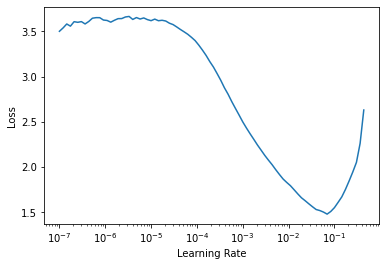

In [20]:
learn.lr_find()

In [21]:
learn.fine_tune(4, 4e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.446340,0.140272,0.953885,01:26


epoch,train_loss,valid_loss,accuracy,time
0,0.179225,0.103071,0.968153,01:28
1,0.141547,0.088596,0.972229,01:27
2,0.087825,0.085081,0.972484,01:26
3,0.057695,0.082361,0.974268,01:24


In [22]:
learn.validate()

(#2) [0.08236068487167358,0.9742675423622131]

In [23]:
learn.save('resnet50_4epochs_4e-4_fp16')

In [58]:
drive_data

'/content/gdrive/My Drive/Colab Notebooks/rakuten/models'

In [59]:
learn.save(f'{drive_data}/resnet50_4epochs_4e-4_fp16')

## Extract Embedding

In [24]:
dls_emb = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, shuffle_train=False)

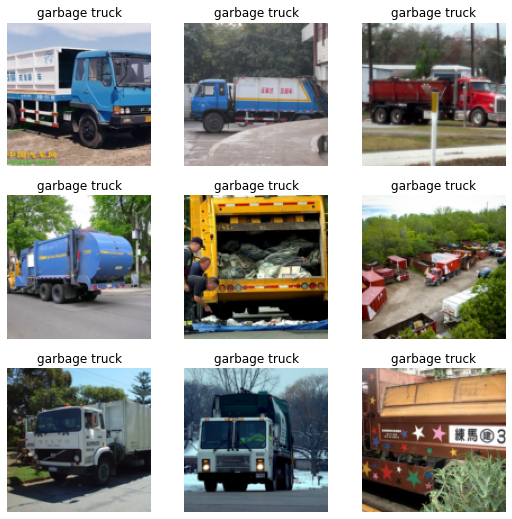

In [25]:
dls_emb.show_batch()

In [26]:
learn_emb2vec = cnn_learner(dls_emb, resnet50, pretrained=True)
learn_emb2vec.load('resnet50_4epochs_4e-4_fp16')

In [27]:
learn_emb2vec.summary()

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 64 x 64    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               64 x 64 x 32 x 32    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 32 x 32    128        True      
________________________________________________________________
Conv2d               64 x 64 x 32 x 32    36,864     False     
_________________________________________________

In [28]:
body = learn_emb2vec.model
del body[-1]

In [29]:
body

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [30]:
layers = list(body.children())

In [31]:
layers

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
layers = layers + [AdaptiveConcatPool2d(), Flatten()]

In [33]:
body = nn.Sequential(*layers)

In [34]:
body

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [35]:
num_features_model(body)

4096

In [36]:
train_ds = dls_emb.train_ds
valid_ds = dls_emb.valid_ds

In [37]:
# Get the label ids from the dataset using map

In [38]:
list(map(lambda x : x[1], train_ds[:10]))

[TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5),
 TensorCategory(5)]

In [39]:
list(map(lambda x: x[0], train_ds[:10]))

[PILImage mode=RGB size=640x457,
 PILImage mode=RGB size=500x375,
 PILImage mode=RGB size=500x375,
 PILImage mode=RGB size=500x375,
 PILImage mode=RGB size=600x536,
 PILImage mode=RGB size=500x334,
 PILImage mode=RGB size=2560x1920,
 PILImage mode=RGB size=500x375,
 PILImage mode=RGB size=500x375,
 PILImage mode=RGB size=500x375]

In [40]:
train_lbl_ids = list(map(lambda x: x[1], train_ds))
valid_lbl_ids = list(map(lambda x: x[1], valid_ds))

In [43]:
L(train_lbl_ids), L(valid_lbl_ids)

((#9469) [TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5)...],
 (#3925) [TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5),TensorCategory(5)...])

In [63]:
dls_emb.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

In [46]:
category_idx = train_lbl_ids[0]
dls_emb.vocab[category_idx]

'garbage truck'

In [50]:
b = dls_emb.one_batch();

In [51]:
train_lbls = list(map(lambda x: dls_emb.vocab[x],  train_lbl_ids))
valid_lbls = list(map(lambda x: dls_emb.vocab[x],  valid_lbl_ids))

In [60]:
train_lbls[:10]

['garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck',
 'garbage truck']

In [52]:
c = Config()

In [53]:
c.d

{'archive_path': '/root/.fastai/archive',
 'data_path': '/root/.fastai/data',
 'model_path': '/root/.fastai/models',
 'storage_path': '/root/.fastai/data',
 'version': 2}

In [54]:
def save_texts(dst, list_of_strings):
  list2str = ', '.join(list_of_strings)
  dst.write(list2str)

In [56]:
def loadtxt_str(path):
  strings = path.open(mode='r').read()
  return stings.split(', ')

In [62]:
np.save(f'{drive_data}/trn_lbl.npy', train_lbls)
np.save(f'{drive_data}/val_lbl.npy', valid_lbls)

In [65]:
save_texts(Path(f'{drive_data}/classes.txt'), dls_emb.vocab)

In [74]:
np.save(f'{drive_data}/trn_names.npy', dls_emb.train.items)
np.save(f'{drive_data}/val_names.npy', dls_emb.valid.items)

We will use bcolz to store our activations in an array that's saved to memory (all won't fit in RAM). Install with 
```
pip install -U bcolz
```

In [66]:
!pip install -U bcolz

     |████████████████████████████████| 1.5MB 8.3MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2667408 sha256=cfd8c5c79cf9898161af1a8748d35d7e52b9ebff4b53380eebcbd1a4203a2040
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [67]:
tmp_path = f'{drive_data}'

In [68]:
body.eval?

In [69]:
body.eval() #equivalent to train
preds = []
with torch.no_grad():
  for x, y in progress_bar(learn_emb2vec.dls.train):
    preds.append(body(x).cpu().numpy())
  for x, y in progress_bar(learn_emb2vec.dls.valid):
    preds.append(body(x).cpu().numpy()) 

In [70]:
preds.shape

AttributeError: ignored

In [71]:
len(preds)

210

In [72]:
preds = np.concatenate(preds, 0); preds.shape

(13394, 4096)

In [75]:
np.save(f'{drive_data}/preds.npy', preds)

In [77]:
train_names = dls_emb.train.items
valid_names = dls_emb.valid.items
names = np.concatenate([train_names, valid_names])

# Nearest Neighbor Comparison

In [78]:
!pip install nmslib -q

     |████████████████████████████████| 13.0MB 241kB/s 
     |████████████████████████████████| 296kB 56.1MB/s 


In [79]:
import nmslib

def create_index(a):
  #index = nmslib.init(space='angulardist')
  index = nmslib.init(space='cosinesimil')
  index.addDataPointBatch(a)
  index.createIndex()
  return index

def get_knns(index, vecs):
  return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [80]:
nn_preds = create_index(preds)

In [86]:
img_path = Path('/root/.fastai/data/imagenette2/val/n03417042').ls()[0]

In [91]:
str(img_path)

'/root/.fastai/data/imagenette2/val/n03417042/ILSVRC2012_val_00028190.JPEG'

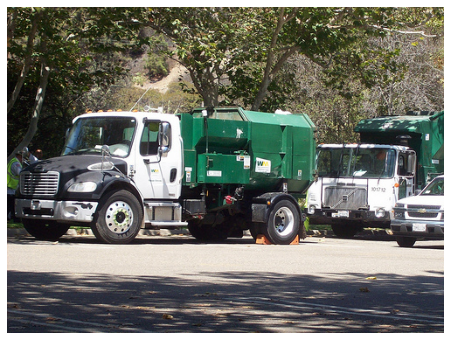

In [87]:
img = TensorImage(PILImage.create(img_path))
img.show(figsize=(12, 6))i

In [95]:
dls_test_ = next(iter(dls_emb.test_dl(test_items=str(img_path))))[0][0]

In [96]:
with torch.no_grad():
  activs = body.eval()(dls_test_[None].cuda())

In [98]:
idxs, dists = get_knn(nn_preds, activs.detach().to('cpu'))

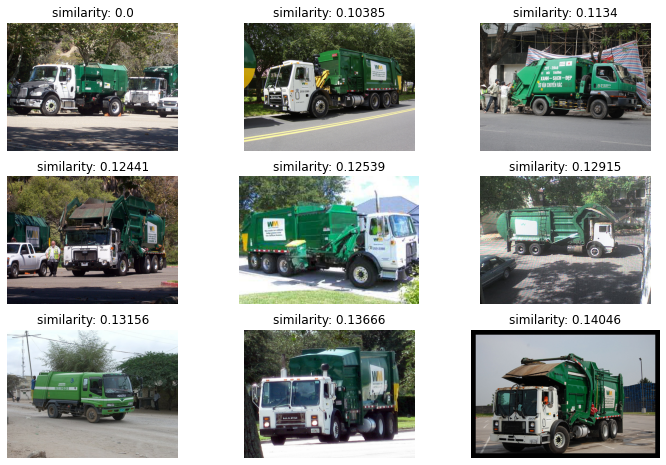

In [102]:
_,axs = plt.subplots(3,3,figsize=(12,8))
for i,ax, dist in zip(idxs[:9], axs.flatten(), dists[:9]):
  sim = round(float(dist), 5)
  title = f'similarity: {sim}'
  TensorImage(PILImage.create(names[i])).show(ax = ax, title=title)